<html lang="en">
<head>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            background-color: #f4f4f4;
            margin: 0;
            padding: 20px;
        }
        h1, h2 {
            color: #2c3e50;
        }
        h1 {
            text-align: center;
            margin-bottom: 20px;
        }
        p {
            margin: 10px 0;
        }
        .code-block {
            background-color: #eaeaea;
            border-left: 5px solid #3498db;
            padding: 10px;
            font-family: "Courier New", Courier, monospace;
            font-size: 14px;
            overflow-x: auto;
        }
        .section-title {
            background-color: #3498db;
            color: white;
            padding: 8px;
            border-radius: 4px;
            margin-top: 20px;
        }
    </style>
</head>
<body>

<h1>Blood Vessel Segmentation in Retinal Images</h1>

<p>This notebook addresses the segmentation of blood vessels in retinal images, a crucial task in detecting diseases such as diabetic retinopathy and glaucoma. The approach utilizes image preprocessing, morphological operations, and thresholding to achieve accurate segmentation.</p>

<div class="section-title">
    <h2>Approach Overview</h2>
</div>

<p>The solution follows a systematic approach for segmenting blood vessels from retinal images using the DRIVE dataset. Below is an explanation of each step, focusing on the theoretical background.</p>

<div class="section-title">
    <h2>1. Image Preprocessing - Contrast Enhancement</h2>
</div>

<p>The first step in this segmentation pipeline is to enhance the contrast of the retinal image. The contrast between the blood vessels and the background is often low, which makes it difficult to distinguish vessels. To address this, we apply the <strong>Contrast Limited Adaptive Histogram Equalization (CLAHE)</strong>.</p>

<p><strong>CLAHE</strong> enhances the local contrast by equalizing the histogram in small regions of the image (tiles), which helps in accentuating the vessels without over-amplifying the noise. By using CLAHE, the blood vessels become more prominent and easier to detect in the next steps.</p>

<div class="section-title">
    <h2>2. Morphological Operations - Blackhat Transform</h2>
</div>

<p>After enhancing the contrast, we use a morphological operation known as the <strong>Blackhat Transform</strong>. This operation helps in emphasizing dark structures (like blood vessels) on a light background. The blackhat transform is defined as:</p>

<div class="code-block">
    Blackhat = Closing of Image - Original Image
</div>

<p>In this context, the blackhat transform highlights the darker vessels, making them stand out against the background. This transform is particularly useful for identifying blood vessels, as they are typically darker than the surrounding retinal tissues.</p>

<div class="section-title">
    <h2>3. Thresholding - Otsu's Method</h2>
</div>

<p>Once the vessels are highlighted using the blackhat operation, the next step is to separate them from the background. We use <strong>Otsu’s Thresholding</strong>, an automatic threshold selection method. Otsu’s method computes an optimal threshold by minimizing intra-class variance between the foreground (vessels) and background.</p>

<p>This results in a binary image where the vessels are segmented as white, and the background is black. Otsu's method works well in cases where the image has distinct intensity levels between the foreground and background.</p>

<div class="section-title">
    <h2>4. Post-processing (Optional)</h2>
</div>

<p>In some cases, small noise or artifacts may still be present in the binary image. To further improve segmentation quality, post-processing techniques like <strong>morphological cleaning</strong> or <strong>connected component analysis</strong> can be applied to remove small false positives or to fill in small gaps in the vessels.</p>

<p>However, in this solution, the initial segmentation results are satisfactory, so additional post-processing may not be required.</p>

<div class="section-title">
    <h2>Conclusion</h2>
</div>

<p>This approach efficiently segments blood vessels in retinal images by leveraging contrast enhancement, morphological operations, and automated thresholding. The use of CLAHE and blackhat transformation improves the visibility of vessels, while Otsu’s method ensures accurate segmentation. This technique is useful in medical imaging applications where blood vessel analysis is critical for disease diagnosis.</p>

</body>
</html>


# Imports

In [1]:
# Common
import time
import os
import csv
import numpy as np

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image
from skimage.morphology import opening, closing, disk, black_tophat

# Constants

In [2]:
TEST_IMG_BASE_PATHS = '/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images'

# Utils

In [3]:
def get_image_paths(directory, valid_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif")):
    image_paths = []
    
    # Iterate over all files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if file is an image based on its extension
            if file.lower().endswith(valid_extensions):
                # Append the full path of the image file to the list
                image_paths.append(os.path.join(root, file))
    
    return image_paths


def plt_img(image, cmap="gray"):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    plt.axis('on')
    plt.show()
    

def plot_image_grid(images, images_per_row=5, total_images=50, cmap="gray"):
    # Ensure we don't exceed the available images or the limit of 50
    total_images = min(total_images, len(images))
    
    # Calculate the number of rows needed
    num_rows = (total_images + images_per_row - 1) // images_per_row

    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    # Flatten the axes array in case of more than one row
    axs = axs.ravel()

    for i in range(total_images):
        # Read and display the image
        img = images[i]
        axs[i].imshow(img, cmap)
        axs[i].axis('off')  # Turn off the axis for clean presentation

    # Turn off any remaining unused subplots (if total_images < images_per_row * num_rows)
    for j in range(total_images, len(axs)):
        axs[j].axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()

# Step1: Visualization

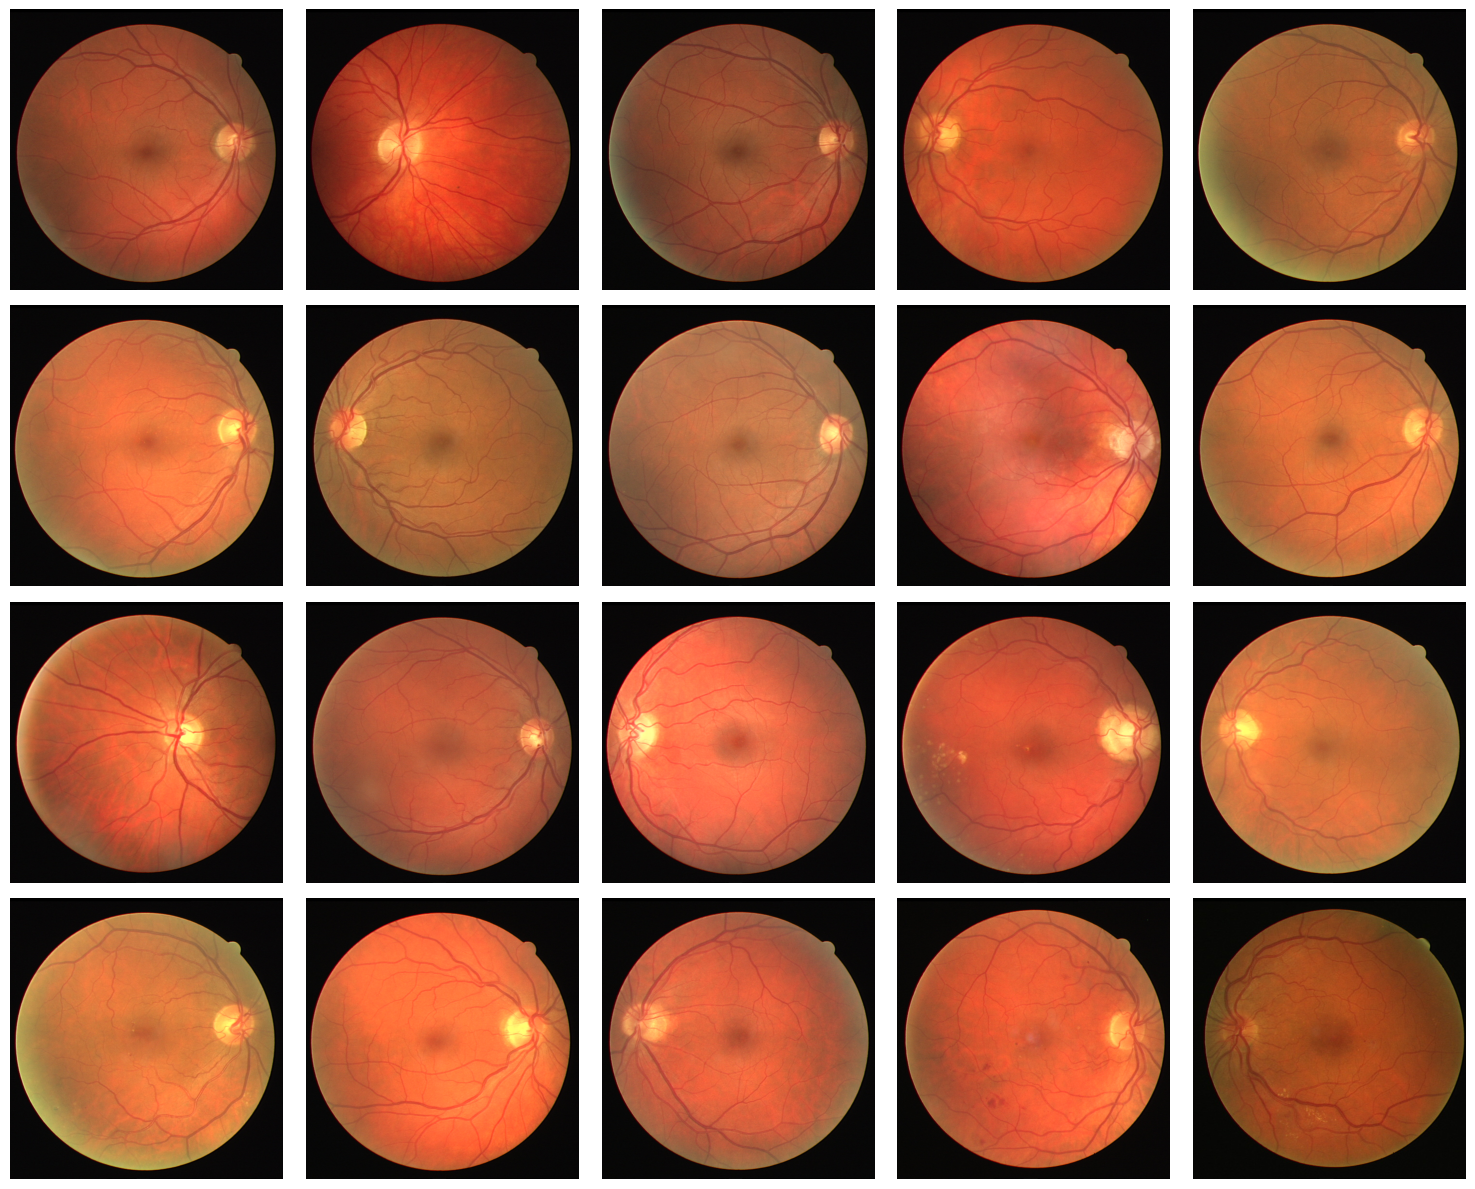

In [4]:
# Read all images path
image_paths = get_image_paths(TEST_IMG_BASE_PATHS)

# Read image using PIL and convert to numpy
test_images = []
for path in image_paths:
    image = Image.open(path)
    image = np.array(image)
    test_images.append(image)
    
# Plot images
plot_image_grid(test_images)

# Step2: Morphological Segmentation

In [5]:
# Assuming test_images is a list of NumPy arrays (grayscale images)
segmented_images = []

for image in test_images:
    # Step 1: Convert to grayscale (if the image is not already grayscale)
    if len(image.shape) == 3:  # Check if the image has multiple channels (RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Preprocessing - Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)

    # Step 3: Morphological operations (e.g., opening)
    selem = disk(6)  # Adjust disk size based on vessel scale
    blackhat_image = black_tophat(enhanced_image, selem)
    
    # Step 4: Thresholding to segment vessels
    # Otsu's thresholding
    _, binary_image = cv2.threshold(blackhat_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step5: Store the segmented image
    segmented_images.append(binary_image)

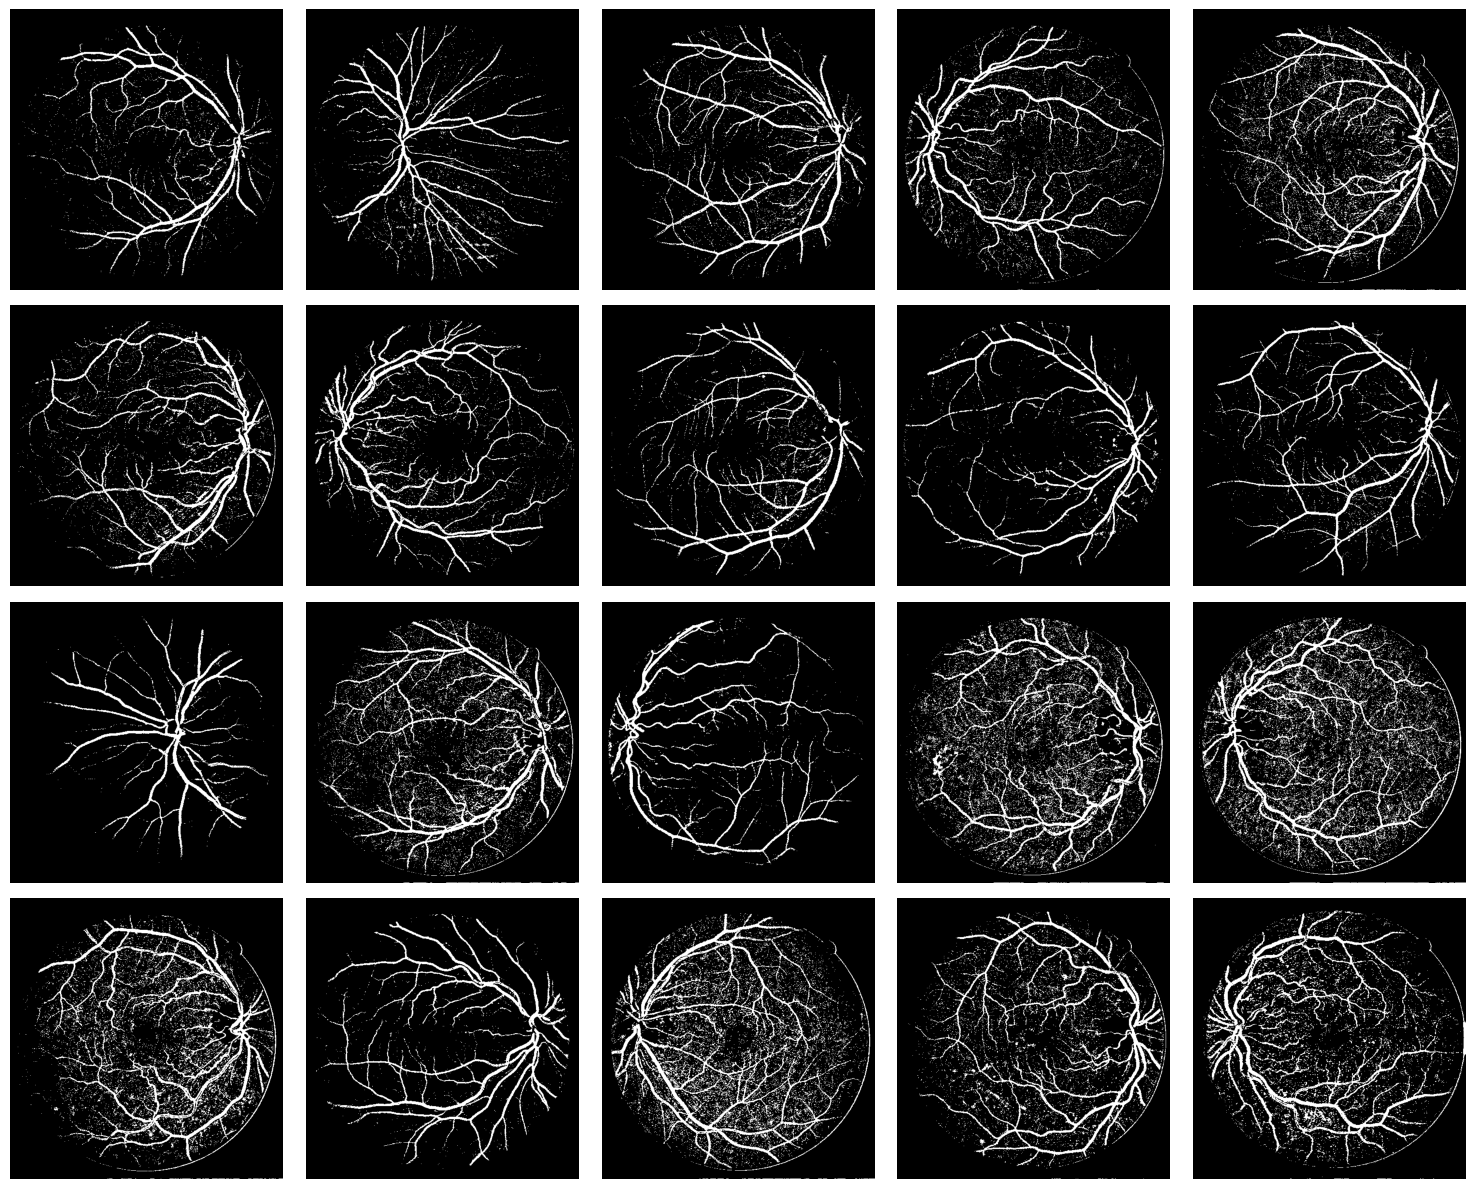

In [6]:
# Plot images
plot_image_grid(segmented_images)